Saving MNIST_ORG.zip to MNIST_ORG.zip


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/50, Loss: 0.7305, accuracy:93.36%
Epoch 2/50, Loss: 0.6572, accuracy:96.35%
Epoch 3/50, Loss: 0.6397, accuracy:97.05%
Epoch 4/50, Loss: 0.6302, accuracy:97.40%
Epoch 5/50, Loss: 0.6229, accuracy:97.70%
Epoch 6/50, Loss: 0.6188, accuracy:97.86%
Epoch 7/50, Loss: 0.6135, accuracy:98.13%
Epoch 8/50, Loss: 0.6104, accuracy:98.17%
Epoch 9/50, Loss: 0.6079, accuracy:98.34%
Epoch 10/50, Loss: 0.6044, accuracy:98.41%
Epoch 11/50, Loss: 0.6031, accuracy:98.54%
Epoch 12/50, Loss: 0.6016, accuracy:98.58%
Epoch 13/50, Loss: 0.6008, accuracy:98.59%
Epoch 14/50, Loss: 0.5998, accuracy:98.64%
Epoch 15/50, Loss: 0.5978, accuracy:98.72%
Epoch 16/50, Loss: 0.5967, accuracy:98.72%
Epoch 17/50, Loss: 0.5957, accuracy:98.81%
Epoch 18/50, Loss: 0.5946, accuracy:98.85%
Epoch 19/50, Loss: 0.5947, accuracy:98.85%
Epoch 20/50, Loss: 0.5939, accuracy:98.87%
Epoch 21/50, Loss: 0.5937, accuracy:98.88%
Epoch 22/50, Loss: 0.5925, accuracy:98.95%
Epoch 23/50, Loss: 0.5923, accuracy:98.89%
Epoch 24/50, Loss: 0

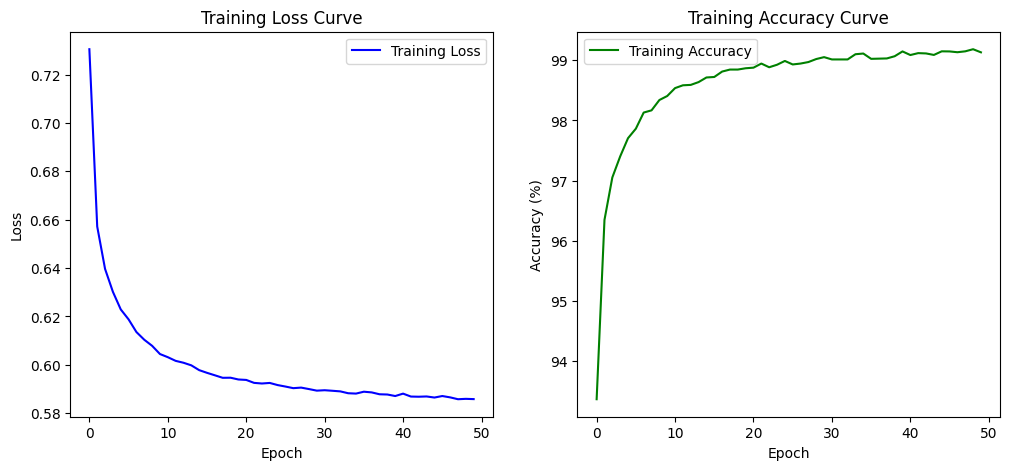

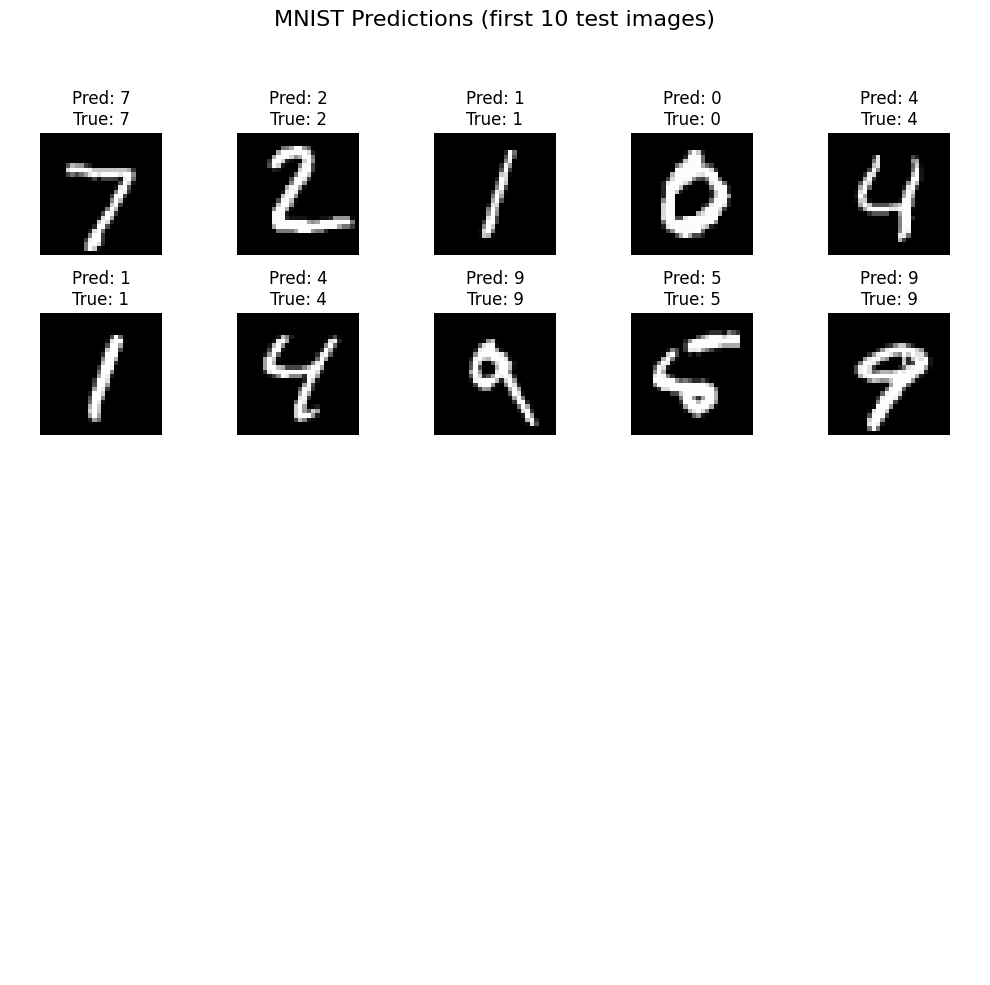

In [5]:
#importing libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# Import idx2numpy
import idx2numpy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, pin_memory=True)
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')

device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')

#creating the nn network
class one_layer_nn(nn.Module):
  def __init__(self ,num_features):
    super().__init__()
    self.flatten=nn.Flatten()
    self.linear_relu_stack=nn.Sequential(
        nn.Linear(num_features,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    return self.linear_relu_stack(x)
#initialising parameters
learning_rate=0.001
epoches=50

#creating model
model=one_layer_nn(28*28)
model=model.to(device)

#loss function defined
loss_fn=nn.CrossEntropyLoss(label_smoothing= 0.1)

#using optimization technique ADAM (could have used momentum ,SGD , RMS prop but found it working better)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=1e-5)

train_losses = []
train_accuracies = []

#starting training model
for epoch in range(epoches):
  total_epoch_loss=0
  correct=0
  total=0
  for batch_features,batch_labels in trainloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    #getting prediction from model(forward propogation)
    pred=model(batch_features)
    #calculating loss
    loss=loss_fn(pred,batch_labels)
     # zero out gradient
    optimizer.zero_grad()
    #backpropogation
    loss.backward()
    #this i also don't know the use , just found it as a solution to overcome 'exploding gradient' problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
     #call to use optimising technique and updating parameters
    optimizer.step()
     #calculating loss and accuracy
    total_epoch_loss+=loss.item()
    correct += (torch.argmax(pred,dim=1) == batch_labels).sum().item()
    total += batch_labels.size(0)
  acc=100.*correct/total
  avg_epoch_loss=total_epoch_loss/len(trainloader)
  train_losses.append(avg_epoch_loss)
  train_accuracies.append(acc)
  print(f"Epoch {epoch+1}/{epoches}, Loss: {avg_epoch_loss:.4f}, accuracy:{acc:.2f}%")

#it is a call to tell that model will now be evaluated on test set
model.eval()

tcorrect=0
ttotal=0
tloss=0
#taking 10 images from test data for prediction
simages, slabels = next(iter(testloader))
simages, slabels = simages[:10], slabels[:10]
simages = simages.to(device)


with torch.no_grad():
  for batch_features,batch_labels in testloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    output=model(batch_features)
    loss=loss_fn(output,batch_labels)
    tloss+=loss.item()
    tcorrect+=(torch.argmax(output,dim=1)==batch_labels).sum().item()
    ttotal+=batch_labels.size(0)
avg_test_loss=tloss/len(testloader)
tacc=100.*tcorrect/ttotal

print(f"Test loss : {avg_test_loss:.4f}, Accuracy: {tacc:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()

model.eval()
with torch.no_grad():
    soutputs = model(simages)
    _, spreds = soutputs.max(1)

simages = simages.cpu()
spreds = spreds.cpu()
slabels = slabels.cpu()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('MNIST Predictions (first 10 test images)', fontsize=16)

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.axis('off')

    if i < 10:
        img = simages[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {spreds[i]}\nTrue: {slabels[i]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




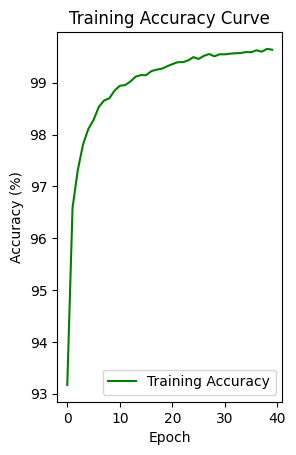

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()

60000 60000 10000 10000
Epoch 1/20, Loss: 0.2092, accuracy:93.83%
Epoch 2/20, Loss: 0.1026, accuracy:96.76%
Epoch 3/20, Loss: 0.0760, accuracy:97.58%
Epoch 4/20, Loss: 0.0636, accuracy:97.92%
Epoch 5/20, Loss: 0.0530, accuracy:98.27%
Epoch 6/20, Loss: 0.0477, accuracy:98.44%
Epoch 7/20, Loss: 0.0416, accuracy:98.64%
Epoch 8/20, Loss: 0.0381, accuracy:98.72%
Epoch 9/20, Loss: 0.0335, accuracy:98.88%
Epoch 10/20, Loss: 0.0315, accuracy:98.90%
Epoch 11/20, Loss: 0.0300, accuracy:99.01%
Epoch 12/20, Loss: 0.0256, accuracy:99.09%
Epoch 13/20, Loss: 0.0280, accuracy:99.03%
Epoch 14/20, Loss: 0.0216, accuracy:99.29%
Epoch 15/20, Loss: 0.0216, accuracy:99.27%
Epoch 16/20, Loss: 0.0200, accuracy:99.34%
Epoch 17/20, Loss: 0.0191, accuracy:99.34%
Epoch 18/20, Loss: 0.0194, accuracy:99.32%
Epoch 19/20, Loss: 0.0178, accuracy:99.42%
Epoch 20/20, Loss: 0.0177, accuracy:99.41%
Test loss : 0.0569, Accuracy: 98.54%


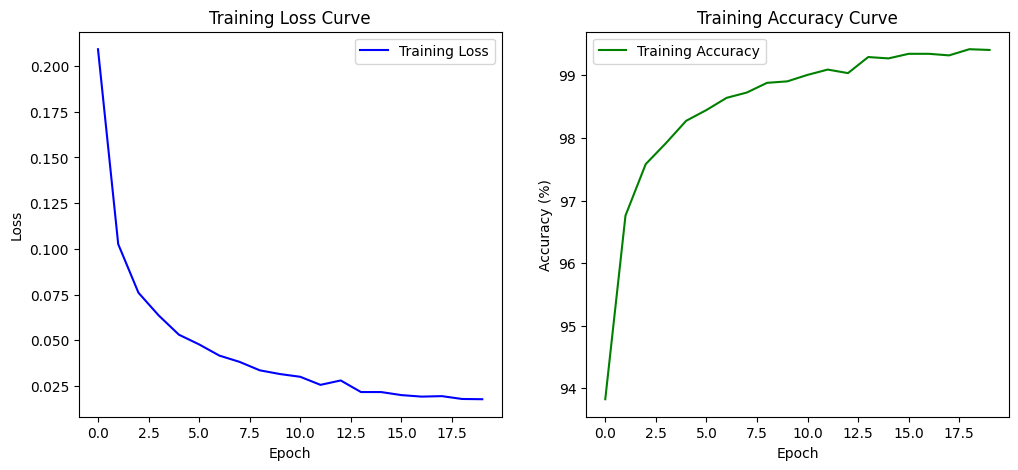

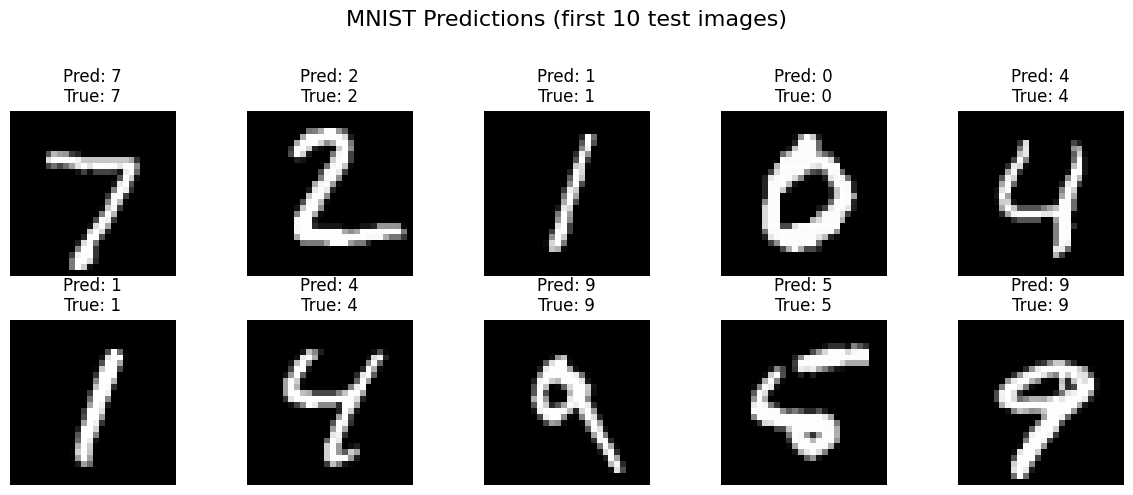

In [ ]:
#importing libraries
!pip install idx2numpy
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import idx2numpy # Import idx2numpy

import zipfile
#extracting file data from zip file
with zipfile.ZipFile("MNIST_ORG.zip",'r') as zip_ref:
  zip_ref.extractall("mnist_data")
import os
os.listdir("mnist_data")
#converting idx datafile into numpy file
images=idx2numpy.convert_from_file("mnist_data/train-images.idx3-ubyte")
labels=idx2numpy.convert_from_file('mnist_data/train-labels.idx1-ubyte')
timages=idx2numpy.convert_from_file('mnist_data/t10k-images.idx3-ubyte')
tlabels=idx2numpy.convert_from_file('mnist_data/t10k-labels.idx1-ubyte')

print(len(images),len(labels),len(timages),len(tlabels))

#convert numpyarray into tensor and scaling features
images = torch.tensor(images / 255.0, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.long)
timages=torch.tensor(timages/255.0,dtype=torch.float32).unsqueeze(1)
tlabels=torch.tensor(tlabels,dtype=torch.long)

mean,std=images.mean(),images.std()

# Standardize
images = (images - mean) / std
timages = (timages - mean) / std

torch.manual_seed(42)

device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')

class customdataset(Dataset):
  def __init__(self,features,labels):
    # Features are already tensors from the conversion above, avoid re-converting
    self.features=features
    self.labels=labels
  def __getitem__(self,index):
    return self.features[index],self.labels[index]
  def __len__(self):
    return len(self.features)

traindataset=customdataset(images,labels)
testdataset=customdataset(timages,tlabels)

trainloader=DataLoader(traindataset,batch_size=64,shuffle=True ,pin_memory=True)
testloader=DataLoader(testdataset,batch_size=64,shuffle=False, pin_memory=True)

# Two-layer NN
class two_layer_nn(nn.Module):
  def __init__(self ,num_features):
    super().__init__()
    self.flatten=nn.Flatten()
    self.linear_relu_stack=nn.Sequential(
        nn.Linear(num_features,512),  # First hidden layer
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512,256), # Second hidden layer
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    return self.linear_relu_stack(x)

learning_rate=0.001
epoches=20


model=two_layer_nn(images.shape[2]*images.shape[3])
model=model.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=1e-6)

train_losses = []
train_accuracies = []

for epoch in range(epoches):
  total_epoch_loss=0
  correct=0
  total=0
  for batch_features,batch_labels in trainloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    pred=model(batch_features)
    loss=loss_fn(pred,batch_labels)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    total_epoch_loss+=loss.item()
    _, predicted = pred.max(1)
    correct += (predicted == batch_labels).sum().item()
    total += batch_labels.size(0)
  acc=100.*correct/total
  avg_epoch_loss=total_epoch_loss/len(trainloader)
  train_losses.append(avg_epoch_loss)
  train_accuracies.append(acc)
  print(f"Epoch {epoch+1}/{epoches}, Loss: {avg_epoch_loss:.4f}, accuracy:{acc:.2f}%")

model.eval()

tcorrect=0
ttotal=0
tloss=0
# Get a batch of images for visualization from the test set
simages_vis, slabels_vis = next(iter(testloader))
# Take the first 10 images from this batch for visualization
simages_vis = simages_vis[:10]
slabels_vis = slabels_vis[:10]
simages_vis = simages_vis.to(device)


with torch.no_grad():
  for batch_features,batch_labels in testloader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    ouput=model(batch_features)
    loss=loss_fn(ouput,batch_labels)
    _,predicted=ouput.max(1)
    tloss+=loss.item()
    tcorrect+=(predicted==batch_labels).sum().item()
    ttotal+=batch_labels.size(0)
avg_test_loss=tloss/len(testloader)
tacc=100.*tcorrect/ttotal

print(f"Test loss : {avg_test_loss:.4f}, Accuracy: {tacc:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()

model.eval()
with torch.no_grad():
    soutputs = model(simages_vis) # Use simages_vis here
    _, spreds = soutputs.max(1)

simages_vis = simages_vis.cpu()
spreds = spreds.cpu()
slabels_vis = slabels_vis.cpu()

fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # Adjusted for 10 images
fig.suptitle('MNIST Predictions (first 10 test images)', fontsize=16)

for i in range(10): # Loop through 10 images
    ax = axes[i // 5, i % 5]
    ax.axis('off')

    img = simages_vis[i].squeeze(0)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {spreds[i].item()}\nTrue: {slabels_vis[i].item()}") # .item() for scalar tensors

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()